In [96]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
import pickle
import joblib
import time
np.random.seed(2)


In [97]:
def load_cls(fname):
    return np.array(pickle.load(open(fname,"rb")))

In [98]:
path = "D:/"
trainSamples = 500
n_iter = 100 
n_trainSamples = [100,250,500,750,1000,1250,1500]
#n_trainSamples = [100,500,1000,10000,20000,50000,75000]

In [99]:
X_train = load_cls(path+"X_train_tokens.p")[:trainSamples]
X_val_cls = load_cls(path+"X_val_tokens.p")

y_train = load_cls(path+"y_train.p")[:trainSamples]
y_val = load_cls(path+"y_val.p")

In [100]:
from sklearn.feature_extraction.text import CountVectorizer

def my_preprocessor(doc):
    return doc

# tokenize the doc and lemmatize its tokens
def my_tokenizer(doc):
    return doc

custom_vec = CountVectorizer(preprocessor=my_preprocessor, tokenizer=my_tokenizer)
cwm = custom_vec.fit_transform(X_train)
tokens = custom_vec.get_feature_names()

In [101]:
from sklearn.feature_extraction.text import TfidfVectorizer,TfidfTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import SGDClassifier

In [102]:
feature_pipeline = Pipeline([
('vect',  CountVectorizer(min_df=.0025, max_df=0.25, ngram_range=(1,3),preprocessor=my_preprocessor, tokenizer=my_tokenizer)),
('tfidf', TfidfTransformer()),
])

In [103]:
X_train_f = feature_pipeline.fit_transform(X_train)
X_val_f =feature_pipeline.transform(X_val_cls)

In [104]:
from sklearn.model_selection import GridSearchCV
parameters = {
    'alpha':[0.0001, 0.001, 0.01],
    'l1_ratio':[0.15,0.30],
    'epsilon':[0.1,0.3,0.5],
    'validation_fraction':[0.1,0.2],
    'n_iter_no_change':[5,10]
 }

In [105]:
sgd_clf = GridSearchCV(SGDClassifier(loss='log',fit_intercept=True,n_iter=n_iter, n_jobs=-1), 
                      parameters,n_jobs=-1, verbose=4, iid=True)

In [106]:
model = sgd_clf.fit(X_train_f, y_train)

C:\Users\prash\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.0s


Fitting 3 folds for each of 72 candidates, totalling 216 fits


[Parallel(n_jobs=-1)]: Done 216 out of 216 | elapsed:    1.3s finished
C:\Users\prash\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


In [107]:
model.best_score_

0.52

In [108]:
print(model.best_params_)
for param_name in sorted(parameters.keys()):
    print("%s: %r" % (param_name, model.best_params_[param_name]))

{'alpha': 0.0001, 'epsilon': 0.1, 'l1_ratio': 0.15, 'n_iter_no_change': 5, 'validation_fraction': 0.1}
alpha: 0.0001
epsilon: 0.1
l1_ratio: 0.15
n_iter_no_change: 5
validation_fraction: 0.1


In [109]:
pickle.dump(model,open("SGDClassifier_"+str(trainSamples)+"_"+str(n_iter)+".pkl",'wb'))

In [110]:
X_test = load_cls(path+"X_test_tokens.p")
y_test = load_cls(path+"y_test.p")

In [111]:
from scipy.stats import rankdata

def mrrs(out, labels):
#     print(out,labels)
    outputs = np.argmax(out,axis=1)
    mrr = 0.0 
    for label,ranks in zip(labels,out):
        ranks = rankdata(ranks*-1)
        rank = ranks[label]
#         print(rank,ranks)
        mrr+=1/rank
    return mrr/len(labels)

def precision_at(out,labels,prank=1):
    count = 0
    for label,ranks in zip(labels,out):
        ranks = rankdata(ranks*-1)
        rank = ranks[label]
#         print(rank,ranks)
        if rank <= prank:
            count+=1
    return count/len(labels)

def mrrwrapper(qid2c,qid2indexmap,preds_prob):
    labels = []
    out = []
    for qid in qid2c.keys():
        scores = []
        for ix in qid2indexmap[qid]:
            if len(scores) < 6:
                scores.append(preds_prob[ix][1])
        if len(scores) < 6:
            continue
        out.append(scores)
        labels.append(int(qid2c[qid]))
    return mrrs(np.array(out),labels),precision_at(np.array(out),labels,1),precision_at(np.array(out),labels,3)

def load_ranking(fname):
    return pickle.load(open(path+"ranking_"+fname+".p","rb"))

In [112]:
from sklearn.metrics import accuracy_score

In [113]:
valAccuracy = []
testAccuracy = []
mrrScore = []
precisionAt1 = []
precisionAt3 = []

# For each of training sample sizes
for eachTrain in n_trainSamples:
    
    # Model with best values from grid search
    bestModel = SGDClassifier(loss='log',alpha=model.best_params_['alpha'],l1_ratio=model.best_params_['l1_ratio'], 
                              epsilon=model.best_params_['epsilon'],validation_fraction = model.best_params_['validation_fraction'],
                              n_iter_no_change=model.best_params_['n_iter_no_change'],
                                   fit_intercept=True, n_iter=n_iter, n_jobs=-1)

    print("SampleSize:",eachTrain)
    
    stime=time.time()
    X_train_f = feature_pipeline.fit_transform(X_train[:eachTrain])
    bestModel.fit(X_train_f,y_train[:eachTrain])   
    print("Train Time:%.2f sec"%(time.time()-stime))
    
    stime=time.time()
    X_val_f = feature_pipeline.transform(X_val_cls)
    preds_val = bestModel.predict(X_val_f)
    accuracy = round(accuracy_score(y_val, preds_val),4)
    valAccuracy.append(accuracy)
    print("Validation Accuracy: %.2f%%" % (accuracy * 100.0))
    print("Validation Time:%.2f sec"%(time.time()-stime))

    stime=time.time()
    X_test_f = feature_pipeline.transform(X_test)
    preds_test = bestModel.predict(X_test_f)
    accuracy = round(accuracy_score(y_test, preds_test),4)
    testAccuracy.append(accuracy)
    print("Test Accuracy: %.2f%%" % (accuracy * 100.0))
    print("Test Time:%.2f sec"%(time.time()-stime))
    
    stime=time.time()
    preds_test_probs = bestModel.predict_proba(X_test_f)
    qid2c,qid2indexmap = load_ranking("test")
    print (mrrwrapper(qid2c,qid2indexmap,preds_test_probs))
    mrr, pAt1, pAt3 = mrrwrapper(qid2c,qid2indexmap,preds_test_probs)
    mrrScore.append(mrr)
    print("MRR:",mrr)
    print("MRR Time:%.2f sec"%(time.time()-stime))
    
    precisionAt1.append(pAt1)
    precisionAt3.append(pAt3)
    
    #input()
print (valAccuracy)
print (testAccuracy)
print (mrrScore)
print (precisionAt1)
print (precisionAt3)

SampleSize: 100
Train Time:0.06 sec


C:\Users\prash\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Validation Accuracy: 49.92%
Validation Time:4.11 sec
Test Accuracy: 49.99%
Test Time:4.19 sec
(0.4253111111111114, 0.18133333333333335, 0.5413333333333333)
MRR: 0.4253111111111114
MRR Time:1.03 sec
SampleSize: 250
Train Time:0.19 sec


C:\Users\prash\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Validation Accuracy: 50.03%
Validation Time:4.15 sec
Test Accuracy: 49.99%
Test Time:4.14 sec
(0.4371212121212127, 0.196, 0.5413333333333333)
MRR: 0.4371212121212127
MRR Time:1.03 sec
SampleSize: 500


C:\Users\prash\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Train Time:0.33 sec
Validation Accuracy: 49.99%
Validation Time:4.20 sec
Test Accuracy: 50.18%
Test Time:4.15 sec
(0.44081111111111243, 0.19533333333333333, 0.5606666666666666)
MRR: 0.44081111111111243
MRR Time:1.04 sec
SampleSize: 750


C:\Users\prash\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Train Time:0.36 sec
Validation Accuracy: 49.99%
Validation Time:4.21 sec
Test Accuracy: 50.19%
Test Time:2.71 sec
(0.439766666666668, 0.19333333333333333, 0.5626666666666666)
MRR: 0.439766666666668
MRR Time:0.48 sec
SampleSize: 1000


C:\Users\prash\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Train Time:0.15 sec
Validation Accuracy: 49.99%
Validation Time:1.72 sec
Test Accuracy: 50.18%
Test Time:1.55 sec
(0.4398111111111123, 0.19333333333333333, 0.5613333333333334)
MRR: 0.4398111111111123
MRR Time:0.48 sec
SampleSize: 1250
Train Time:0.15 sec


C:\Users\prash\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Validation Accuracy: 49.99%
Validation Time:1.74 sec
Test Accuracy: 50.18%
Test Time:3.83 sec
(0.4401888888888902, 0.194, 0.562)
MRR: 0.4401888888888902
MRR Time:1.06 sec
SampleSize: 1500


C:\Users\prash\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Train Time:0.35 sec
Validation Accuracy: 49.99%
Validation Time:4.25 sec
Test Accuracy: 50.19%
Test Time:4.17 sec
(0.44107777777777907, 0.196, 0.5626666666666666)
MRR: 0.44107777777777907
MRR Time:0.93 sec
[0.4992, 0.5003, 0.4999, 0.4999, 0.4999, 0.4999, 0.4999]
[0.4999, 0.4999, 0.5018, 0.5019, 0.5018, 0.5018, 0.5019]
[0.4253111111111114, 0.4371212121212127, 0.44081111111111243, 0.439766666666668, 0.4398111111111123, 0.4401888888888902, 0.44107777777777907]
[0.18133333333333335, 0.196, 0.19533333333333333, 0.19333333333333333, 0.19333333333333333, 0.194, 0.196]
[0.5413333333333333, 0.5413333333333333, 0.5606666666666666, 0.5626666666666666, 0.5613333333333334, 0.562, 0.5626666666666666]


In [114]:
def accuracyVisualization():
    ''' Plots the data points with the centroids
    '''
    fig = plt.figure()
    ax = plt.axes()
    ax.plot(n_trainSamples,testAccuracy,label='TestAccuracy vs TrainData',marker='o')
    ax.plot(n_trainSamples,valAccuracy,label='ValAccuracy vs TrainData',marker='.')
    plt.title("Scores vs TrainData")
    plt.legend()
    plt.xlabel("TrainData")
    plt.ylabel("Scores")
    fig.savefig("SGDClassifier_Accuracy.png")
    #plt.show()

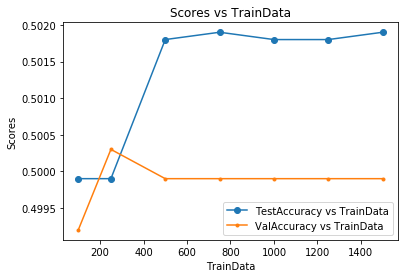

In [115]:
accuracyVisualization()

In [116]:
def mrrVisualization():
    ''' Plots the data points with the centroids
    '''
    fig = plt.figure()
    ax = plt.axes()
    ax.plot(n_trainSamples,mrrScore,label='MRR vs TrainData',marker='x')
    plt.title("Scores vs TrainData")
    plt.legend()
    plt.xlabel("TrainData")
    plt.ylabel("Scores")
    fig.savefig("SGDClassifier_Mrr.png")
    plt.show()

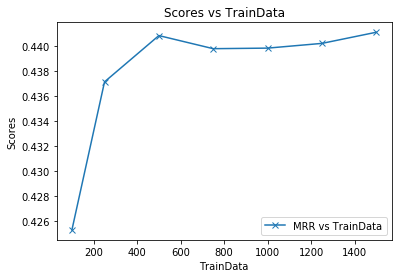

In [117]:
mrrVisualization()